In [139]:
#Lista 4

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

P1

Definiré el método de Newton y las funciones necesarias para implementarlo.

In [140]:
#Esta función me devuelve la matriz jacobiana del esquema
def Matriz(xñ,yñ,n,EI,W0,L,hx):
    x = xñ.copy()
    y = yñ.copy()
    B = np.zeros((n-2,n-2))
    for i in range(n-2):
        B[i,i] = -2/hx/hx
    
    for i in range(1,n-3):

        B[i,i-1] = (1/hx/hx - ((3*W0) / (8*EI*(hx**2))) * (L*x[i] - x[i]**2) * (y[i-1] + y[i+1]) *
                    (1 + ((y[i-1]+y[i+1])/(2*hx))**2)**(1/2))
        B[i,i+1] = (1/hx/hx - ((3*W0) / (8*EI*(hx**2))) * (L*x[i] - x[i]**2) * (y[i-1] + y[i+1]) *
                    (1 + ((y[i-1]+y[i+1])/(2*hx))**2)**(1/2))

    B[0,1] = B[1,0]
    B[-1,-2] = B[-2,-1]

    return B

#Esta función me devuelve el vector con las f_i
def F(xñ,yñ,n,EI,W0,L,hx):
    x = xñ.copy()
    y = yñ.copy()
    v = np.zeros(n-2)

    for i in range(1, n-3):
        v[i] = ((y[i-1]-2*y[i] + y[i+1]) / (hx**2) - (W0 / (2*EI)) * (L*x[i] - x[i]**2) *
                (1 + ((y[i-1]+y[i+1])/(2*hx))**2)**(3/2))
        
    v[0] = ((-2*y[1] + y[2]) / (hx**2) - (W0 / (2*EI)) * (L*x[1] - x[1]**2) *
            (1 + (y[2]/(2*hx))**2)**(3/2))
    v[-1] = ((y[-2-1]-2*y[-1-1]) / (hx**2) - (W0 / (2*EI)) * (L*x[-1-1] - x[-1-1]**2) *
            (1 + (y[-2-1]/(2*hx))**2)**(3/2))
    return v

#Método de Newton
def Newton(x, y0, J, F, EI, W0, L, maxit, tol):
    n = len(x)
    hx = L / n
    cond = True
    i = 0
    y = y0.copy()

    while cond and i <= maxit:
        Jacobian = J(x,y,n,EI,W0,L,hx)
        f_vector = F(x,y,n,EI,W0,L,hx)
        delta_y = np.zeros(n)
        delta_y[1:n-1] = np.linalg.solve(Jacobian, -f_vector)
        y = y + delta_y
        cond = np.linalg.norm(delta_y) > tol
        i += 1
    return y

Parametros del problema.

In [141]:
#Valores
EI = 1.5*1e7
L = 7
W0 = 15*1e3
x = np.linspace(0,7,100)
y0 = np.array([0 for i in range(100)])
maxit = 400
tol = 1e-5

In [142]:
sol = Newton(x, y0, Matriz, F, EI, W0, L, maxit, tol)

Gráfico.

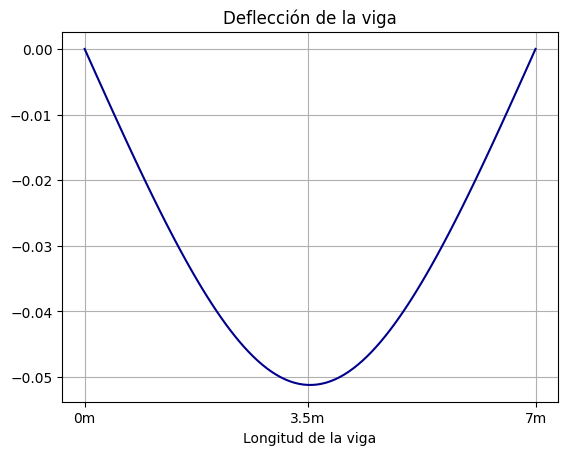

In [143]:
fig, ax = plt.subplots(1,1)
plt.plot(sol, color='darkblue')
plt.title('Deflección de la viga')
plt.xlabel('Longitud de la viga')
new_ticks = [0, 49, 99]  
new_tick_labels = ['0m', '3.5m', '7m'] 

plt.grid()
plt.xticks(new_ticks, new_tick_labels)
plt.show()

P2

Defino la función que implementa Lax-Wendroff de un paso.

In [144]:
def Lax_Wendroff(U0, a, interval, T, ht, hx):
    n = int((interval[1] - interval[0]) / hx)
    m = int(T/ht)

    grilla_x = np.linspace(interval[0], interval[1], n)
    u = U0(grilla_x, n)

    c = a * ht / hx

    A = np.eye(n) * (1 - c**2)
    sub_diag = np.ones(n-1) * c * (1+c) / 2
    supra_diag = np.ones(n-1) * (c * (1-c) / 2)
    lower = np.diag(sub_diag,-1)
    upper = np.diag(supra_diag,1)
    A += lower - upper
    
    sol = np.zeros((m, n))
    sol[0,:] = u
    for i in range(1, m):
        sol[i,:-1] = (A @ u)[:-1]
        sol[i,-1] = c * (1+c) / 2 * u[-2] + (1 - c**2) * u[-1] - (c * (1-c) / 2) * u[-1]
        u = sol[i,:]

    return sol


Parametros de el problema.

In [145]:
a = 0
b = 10
a0 = 1
T = 17
hx = 0.05
ht = hx*0.8

Defino la función que describe la condición inicial del sistema. Esto será hecho como una lista en el intrevalo espacial dado con valores de la función evaluada a lo largo de este.

In [146]:
def U(x, l):
    lista = np.zeros(l)
    for i in range(len(x)):
        lista[i] = np.exp(-20*(x[i]-2)**2) + np.exp(-(x[i]-5)**2)
    return lista

In [147]:
sol = Lax_Wendroff(U, a0, [a,b], T, ht, hx)

Gráfico.

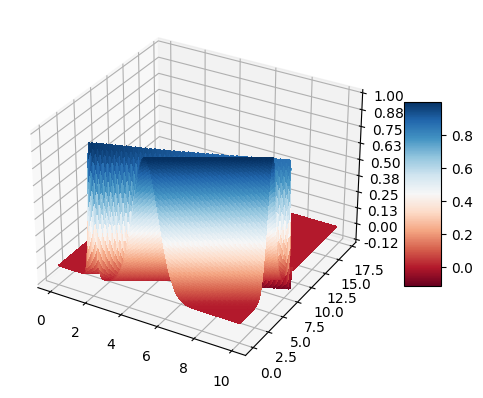

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use add_subplot to create 3D axes

y = np.linspace(0, T, int(T/ht))
x = np.linspace(a, b, int((b-a)/hx))
X, Y = np.meshgrid(x, y)  # grid of points

surf = ax.plot_surface(X, Y, sol, rstride=1, cstride=1,
                      cmap=cm.RdBu, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Una mejor forma de vizualizar la solución será graficando algunos estados de esta en 2d para distintos instantes de tiempo.

[]

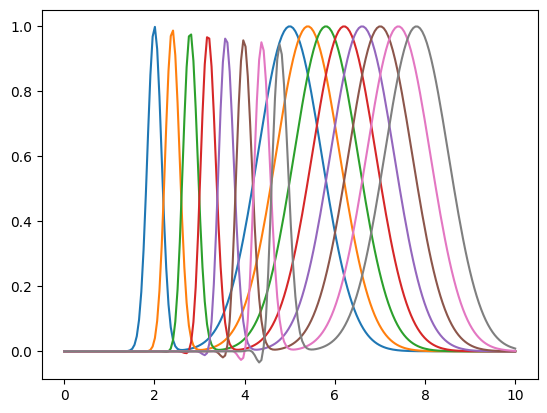

In [149]:
fig, ax = plt.subplots(1,1)
x = np.linspace(0,10,int(10/hx))
for i in range(0,80,10):
    ax.plot(x, sol[i,:])
plt.plot()

Se puede ver claramente que la solución de la ecuación diferencial es una onda viajera. También es notable un pequeño error de la solución dada por el método, ya que vemos que la onda viajera toma valores por debajo del 0, esto se puede solucionar refinando las grillas espacial y temporal.

[]

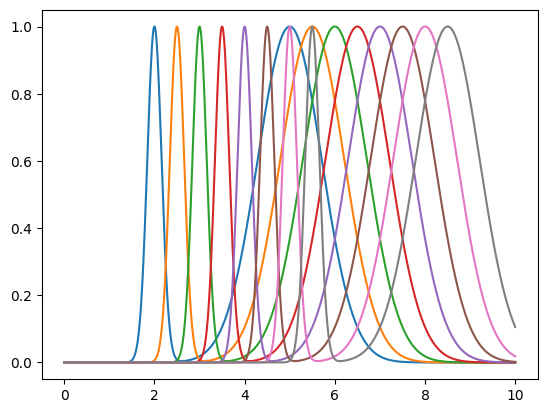

In [150]:
ht_refinado = 0.005
hx_refinado = 0.008
sol_refinada = Lax_Wendroff(U, a0, [a,b], T, ht_refinado, hx_refinado)

fig1, ax1 = plt.subplots(1,1)
x = np.linspace(0,10,int(10/hx_refinado))
for i in range(0,800,100):
    ax1.plot(x, sol_refinada[i,:])
plt.plot()